# Unit Commitment with Quantum-Inspired PSO (QPSO)

## Abstract
This notebook implements a quantum-inspired swarm optimization approach to the Unit Commitment problem using Quantum-behaved Particle Swarm Optimization (QPSO). The objective is to minimize generation cost while satisfying power-demand balance and operational constraints, and to provide a direct comparison point against a classical swarm baseline.

## How to Run
- Python 3.9+
- Run all cells from top to bottom.
- All required libraries must be installed beforehand.

## Problem Context & Objective
The Unit Commitment problem determines which generation units should be ON or OFF across a scheduling horizon in order to minimize total operating cost while meeting electricity demand and respecting technical constraints.

## Notebook Structure
- Method
- Implementation
- Results
- Discussion
- Key Takeaways
- References

## Related Notebook
- Classical baseline: **unit_commitment_mopso_classical.ipynb** (in your ML/Optimization repo)


# Unit Commitment with Quantum-Inspired PSO (QPSO)
This notebook re-solves the same **unit commitment** instance using **Quantum-Inspired Particle Swarm Optimization (QPSO)** and compares its Pareto frontier to the MOPSO baseline.

> QPSO is “quantum-inspired” because its position update is derived from a probabilistic model of particle motion (no explicit velocity), producing broader exploration while retaining PSO-style exploitation through personal/global attractors.

## QPSO: key idea
In standard PSO, each particle has a position and a velocity. In **QPSO**, particles do not carry velocities; instead, a particle samples a new position around an **attractor** point.

For each decision variable:
- Compute an attractor \(p\) combining personal best and a leader (global/archived best).
- Compute \(m_{best}\): mean of the swarm’s personal best positions (dimension-wise).
- Sample:
\[
x \leftarrow p \pm \beta |m_{best} - x| \ln(1/u), \quad u\sim U(0,1)
\]
where \(\beta\) controls exploration (often decreased over iterations).

We keep the same feasibility repair and Pareto archive logic as in the baseline to ensure valid schedules and comparable trade-offs.

In [1]:

import random, copy, math
import numpy as np
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)


In [2]:
# Problem data
units = {
    "Unit A": {"P_min": 20, "P_max": 100, "c": 20, "S": 100, "e": 0.9, "E_start": 2.0},
    "Unit B": {"P_min": 0,  "P_max": 80,  "c": 40, "S": 10,  "e": 0.1, "E_start": 0.5},
}
demand = [60, 90, 110, 70]
unit_names = list(units)
T = len(demand)
print("Units:", unit_names, "| Hours:", T)


Units: ['Unit A', 'Unit B'] | Hours: 4


In [3]:
# Objectives
def cost(schedule, units=units):
    return sum(u["c"]*h["generation"] + u["S"]*h["startup"]
               for name, hours in schedule.items()
               for h, u in [(hh, units[name]) for hh in hours])

def emissions(schedule, units=units):
    return sum(u["e"]*h["generation"] + u["E_start"]*h["startup"]
               for name, hours in schedule.items()
               for h, u in [(hh, units[name]) for hh in hours])

def evaluate(schedule):
    return cost(schedule), emissions(schedule)


In [4]:
# Pareto archive
def dominates(a_cost, a_em, b_cost, b_em):
    return (a_cost <= b_cost and a_em <= b_em) and (a_cost < b_cost or a_em < b_em)

def update_archive(archive, pos, c, e):
    if math.isinf(c) or math.isinf(e):
        return archive
    if any(dominates(s["cost"], s["emissions"], c, e) for s in archive):
        return archive
    archive = [s for s in archive if not dominates(c, e, s["cost"], s["emissions"])]
    archive.append({"pos": copy.deepcopy(pos), "cost": c, "emissions": e})
    return archive


In [5]:
# Repair to guarantee feasibility
def repair(schedule, units=units, demand=demand):
    sch = copy.deepcopy(schedule)

    score = {n: units[n]["c"] + 100*units[n]["e"] for n in units}
    order_inc = sorted(units, key=lambda n: score[n])
    order_dec = sorted(units, key=lambda n: score[n], reverse=True)

    for t in range(len(demand)):
        gen_t = sum(sch[n][t]["generation"] for n in units)

        if gen_t < demand[t]:
            need = demand[t] - gen_t
            for n in order_inc:
                if need <= 0: break
                Pmin, Pmax = units[n]["P_min"], units[n]["P_max"]
                p = sch[n][t]["generation"]
                if p == 0:
                    add = min(Pmax, max(Pmin, need))
                else:
                    add = min(need, Pmax - p)
                sch[n][t]["generation"] = p + add
                need -= add

        gen_t = sum(sch[n][t]["generation"] for n in units)
        if gen_t > demand[t]:
            excess = gen_t - demand[t]
            for n in order_dec:
                if excess <= 0: break
                Pmin = units[n]["P_min"]
                p = sch[n][t]["generation"]
                if p <= 0: continue
                reducible = p - Pmin if Pmin > 0 else p
                dec = min(excess, max(0, reducible))
                sch[n][t]["generation"] = p - dec
                if sch[n][t]["generation"] <= 0:
                    sch[n][t]["generation"] = 0
                excess -= dec

    for n in units:
        prev_on = False
        for t in range(len(demand)):
            on = sch[n][t]["generation"] > 0
            sch[n][t]["startup"] = 1 if (on and (t == 0 or not prev_on)) else 0
            prev_on = on

    return sch

def random_schedule():
    sch = {
        n: [{"generation": (random.uniform(units[n]["P_min"], units[n]["P_max"]) if random.random() < 0.5 else 0),
             "startup": 0} for _ in range(T)]
        for n in units
    }
    return repair(sch)

def gen_matrix(schedule):
    return np.array([[schedule[n][t]["generation"] for t in range(T)] for n in unit_names], dtype=float)

def set_matrix(schedule, mat):
    sch = copy.deepcopy(schedule)
    for i,n in enumerate(unit_names):
        for t in range(T):
            sch[n][t]["generation"] = float(mat[i,t])
    return repair(sch)


In [6]:
# Baseline MOPSO
class PSOParticle:
    def __init__(self):
        self.position = random_schedule()
        self.velocity = {n: [random.uniform(-50, 50) for _ in range(T)] for n in units}
        self.cost, self.em = evaluate(self.position)
        self.pbest_pos = copy.deepcopy(self.position)
        self.pbest_cost, self.pbest_em = self.cost, self.em

    def step(self, leader_pos, w=0.7, c1=1.4, c2=1.4):
        for n in units:
            Pmax = units[n]["P_max"]
            for t in range(T):
                x = self.position[n][t]["generation"]
                v = self.velocity[n][t]
                pbest = self.pbest_pos[n][t]["generation"]
                gbest = leader_pos[n][t]["generation"]
                r1, r2 = random.random(), random.random()
                v = w*v + c1*r1*(pbest - x) + c2*r2*(gbest - x)
                self.velocity[n][t] = v
                self.position[n][t]["generation"] = max(0, min(Pmax, x + v))
        self.position = repair(self.position)
        self.cost, self.em = evaluate(self.position)
        if dominates(self.cost, self.em, self.pbest_cost, self.pbest_em):
            self.pbest_pos = copy.deepcopy(self.position)
            self.pbest_cost, self.pbest_em = self.cost, self.em

def run_mopso(n_particles=30, n_iters=150, seed=0):
    random.seed(seed)
    swarm = [PSOParticle() for _ in range(n_particles)]
    archive = []
    for p in swarm:
        archive = update_archive(archive, p.position, p.cost, p.em)
    for _ in range(n_iters):
        leader = random.choice(archive)["pos"] if archive else random.choice(swarm).position
        for p in swarm:
            p.step(leader)
            archive = update_archive(archive, p.position, p.cost, p.em)
    return sorted(archive, key=lambda s: s["cost"])


In [7]:
# QPSO implementation (multi-objective via the same Pareto archive leaders)
class QParticle:
    def __init__(self):
        self.position = random_schedule()
        self.cost, self.em = evaluate(self.position)
        self.pbest_pos = copy.deepcopy(self.position)
        self.pbest_cost, self.pbest_em = self.cost, self.em

    def pbest_matrix(self):
        return gen_matrix(self.pbest_pos)

def run_qpso(n_particles=30, n_iters=150, beta_start=1.0, beta_end=0.5, seed=0):
    random.seed(seed)
    np.random.seed(seed)

    swarm = [QParticle() for _ in range(n_particles)]
    archive = []
    for p in swarm:
        archive = update_archive(archive, p.position, p.cost, p.em)

    for it in range(n_iters):
        # mean best across pbest positions
        mbest = np.mean([p.pbest_matrix() for p in swarm], axis=0)

        # anneal beta
        beta = beta_start + (beta_end - beta_start) * (it / max(1, n_iters-1))

        for p in swarm:
            leader = random.choice(archive)["pos"] if archive else random.choice(swarm).position

            X = gen_matrix(p.position)
            Pp = gen_matrix(p.pbest_pos)
            Pg = gen_matrix(leader)

            phi = np.random.rand(*X.shape)
            attractor = phi * Pp + (1 - phi) * Pg

            u = np.random.rand(*X.shape)
            u = np.clip(u, 1e-12, 1-1e-12)
            step = beta * np.abs(mbest - X) * np.log(1.0 / u)

            sign = np.where(np.random.rand(*X.shape) < 0.5, 1.0, -1.0)
            X_new = attractor + sign * step

            # clip by unit max (min handled by repair when turning on)
            for i,n in enumerate(unit_names):
                X_new[i,:] = np.clip(X_new[i,:], 0.0, units[n]["P_max"])

            p.position = set_matrix(p.position, X_new)
            p.cost, p.em = evaluate(p.position)

            if dominates(p.cost, p.em, p.pbest_cost, p.pbest_em):
                p.pbest_pos = copy.deepcopy(p.position)
                p.pbest_cost, p.pbest_em = p.cost, p.em

            archive = update_archive(archive, p.position, p.cost, p.em)

    return sorted(archive, key=lambda s: s["cost"])


In [8]:
# Run both methods and compare Pareto frontiers
frontier_mopso = run_mopso(seed=0)
frontier_qpso  = run_qpso(seed=0)

print("MOPSO solutions:", len(frontier_mopso))
print("QPSO  solutions:", len(frontier_qpso))


MOPSO solutions: 4488
QPSO  solutions: 4490


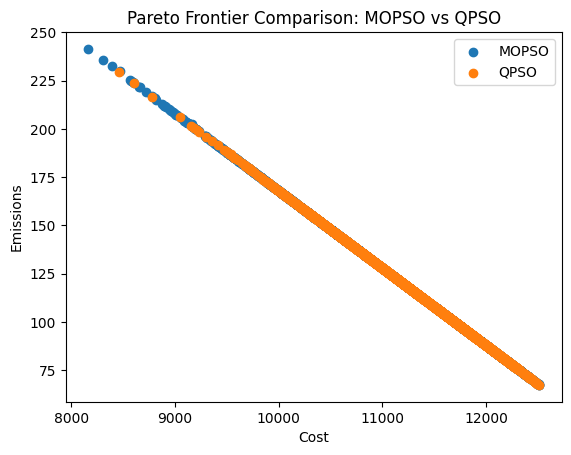

In [9]:
# Plot comparison
plt.figure()
plt.scatter([s["cost"] for s in frontier_mopso], [s["emissions"] for s in frontier_mopso], label="MOPSO")
plt.scatter([s["cost"] for s in frontier_qpso],  [s["emissions"] for s in frontier_qpso],  label="QPSO")
plt.xlabel("Cost")
plt.ylabel("Emissions")
plt.title("Pareto Frontier Comparison: MOPSO vs QPSO")
plt.legend()
plt.show()


## Key Takeaways
* QPSO introduces quantum-inspired exploration dynamics that can improve search behavior in non-convex optimization landscapes.
* The resulting schedule and cost provide a direct comparison point against the classical MOPSO baseline.
* This notebook demonstrates a practical quantum-inspired optimization template that can be extended to larger UC instances and constraint variants.